# Рябиков Илья. Лабораторная работа №2

## Импорт библиотек и загрузка данных

### Библиотеки

Первым делом импортируем библиотеки и подгрузим данные об акции, которая мне досталась - это Майкрософт

In [1]:
! pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 12.8 MB/s 


In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
!pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 15.1 MB/s 
     |████████████████████████████████| 217 kB 57.7 MB/s 
     |████████████████████████████████| 1.8 MB 49.3 MB/s 
     |████████████████████████████████| 136 kB 76.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 793 kB 56.9 MB/s 
     |████████████████████████████████| 6.9 MB 23.6 MB/s 
     |████████████████████████████████| 7.5 MB 56.7 MB/s 
     |████████████████████████████████| 177 kB 80.1 MB/s 
     |████████████████████████████████| 2.5 MB 43.4 MB/s 
     |████████████████████████████████| 228 kB 60.2 MB/s 
     |████████████████████████████████| 137 kB 39.1 MB/s 
     |████████████████████████████████| 11.2 MB 18.8 MB/s 
     |██████████████████████████████

In [28]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 14.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import datetime
import yfinance as yf

from sklearn.model_selection import train_test_split


from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from scipy.stats import norm
import scipy
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import scipy.stats as scs

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA as ARIMA_1

from arch import arch_model

### Загрузка данных

In [6]:
my_stock = 'MSFT'

In [7]:
today = date.today()

Начальной датой поставим дату 10 лет назад (10*365 дней в году) - из-за високосных лет может быть погрешность в несколько дней, но в целом при общем количестве временных периодов в 3,5 тыс. эти несколько дней вряд ли повлияют на модель, учитывая что 10 лет назад у Майкрософт не было серьезных скачков или падений цены

In [8]:
start_date = today - datetime.timedelta(days=365*10)

In [9]:
start_date

datetime.date(2012, 10, 7)

In [10]:
df = yf.download(my_stock, start_date, today)

[*********************100%***********************]  1 of 1 completed


In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-10-08 00:00:00-04:00,29.639999,29.920000,29.549999,29.780001,24.424265,29752000
2012-10-09 00:00:00-04:00,29.680000,29.740000,29.180000,29.280001,24.014189,45121100
2012-10-10 00:00:00-04:00,29.150000,29.309999,28.950001,28.980000,23.768135,47227100
2012-10-11 00:00:00-04:00,29.219999,29.250000,28.870001,28.950001,23.743532,41488500
2012-10-12 00:00:00-04:00,28.969999,29.320000,28.799999,29.200001,23.948578,46464700


Расчитываем лог-доходности по скорректированной на дивиденды цене акций

In [12]:
df['log_rtns'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df = df.dropna()

Построим график нашего временного ряда

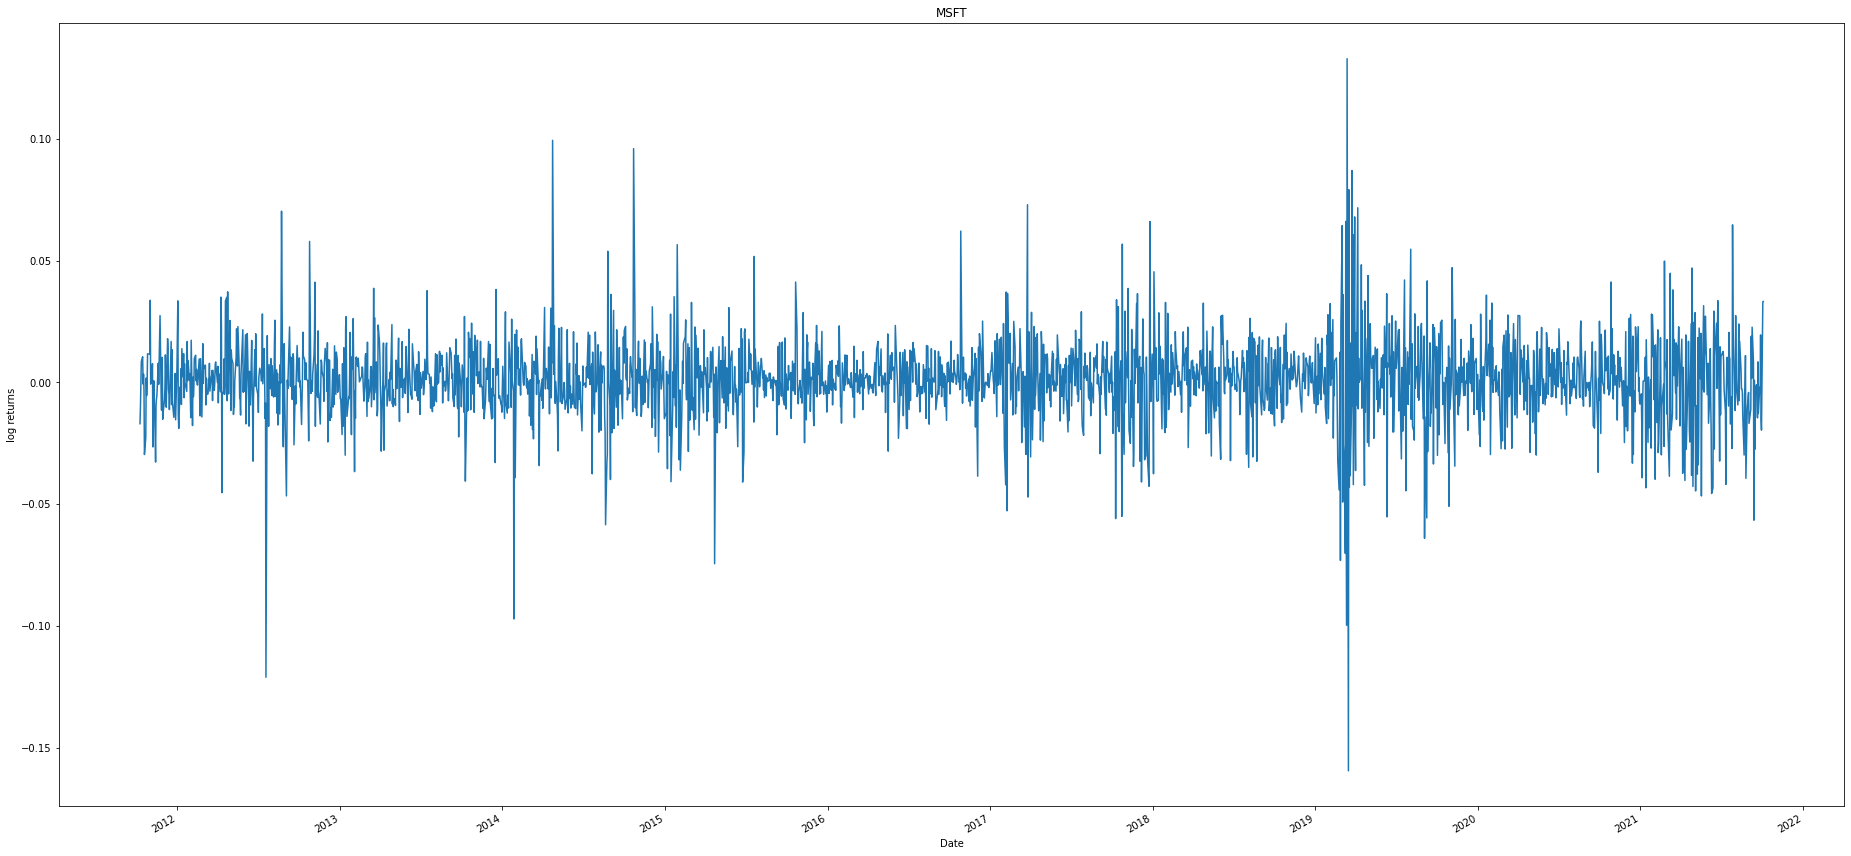

In [31]:
daily_returns = df['log_rtns']
_ = daily_returns.plot()
plt.ylabel('log returns')
plt.title(my_stock)
plt.rcParams['figure.figsize'] = [32, 16]
plt.show()

## Подготовка к построению моделей

### Train и Test части модели

Разделим выборку на train и test

In [14]:
daily_returns.sort_index(inplace=True)

In [18]:
x_train, x_test = train_test_split(daily_returns, test_size=0.33, shuffle=False) 

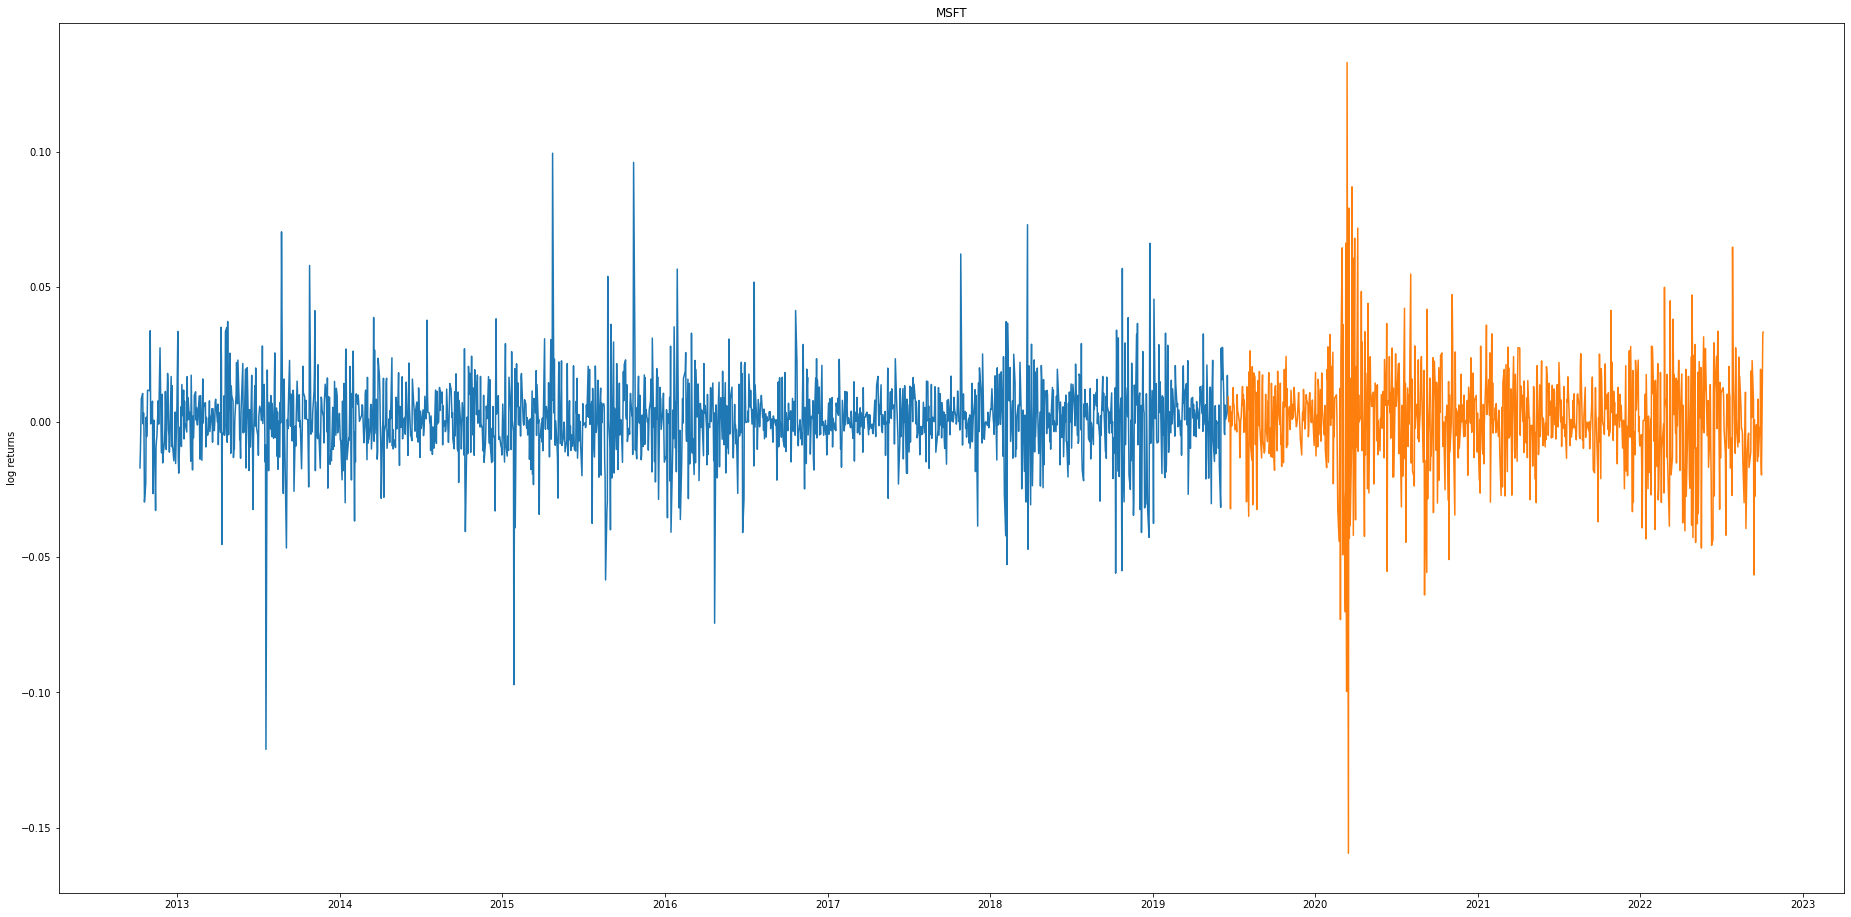

In [30]:
plt.ylabel('log returns')
plt.plot(x_train)
plt.plot(x_test)
plt.title(my_stock)
plt.rcParams['figure.figsize'] = [32, 16]
plt.show()

In [16]:
x_train.index = pd.DatetimeIndex(x_train.index).to_period('D')
x_test.index = pd.DatetimeIndex(x_test.index).to_period('D')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Далее будем изучать особенности обучающей выборки и строить модели для нее, а затем протестируем полученные модели на тестовой выборке

### Характеристики обучающей выборки

Построим графики автокорреляции (ACF) и частичной автокорреляции (PACF) для понимания степени зависимости доходности от самой себя на предыдущих временных шагах 

График автокорреляции

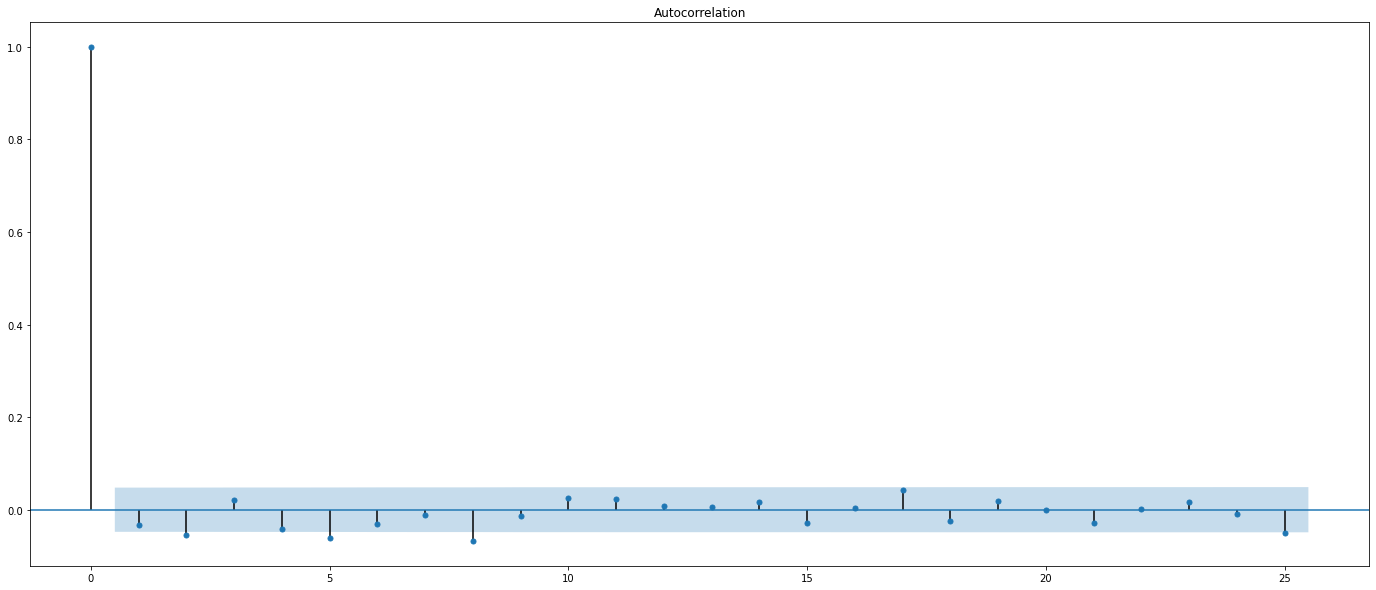

In [ ]:
plt.rc("figure", figsize=(24,10))
fig = plot_acf(x_train.values.squeeze(), lags=25)

График частичной автокорреляции

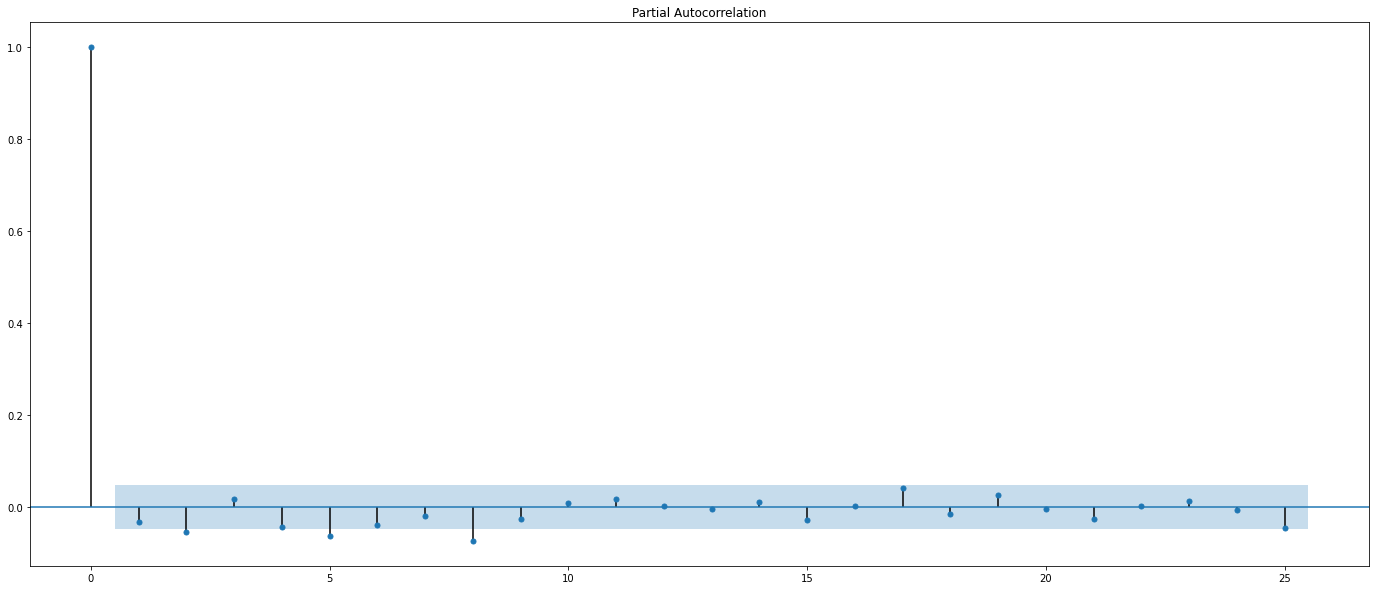

In [ ]:
fig = plot_pacf(x_train.values.squeeze(), lags=25)

Также построим графики, которые покажут, насколько наше распределение похоже на нормальное

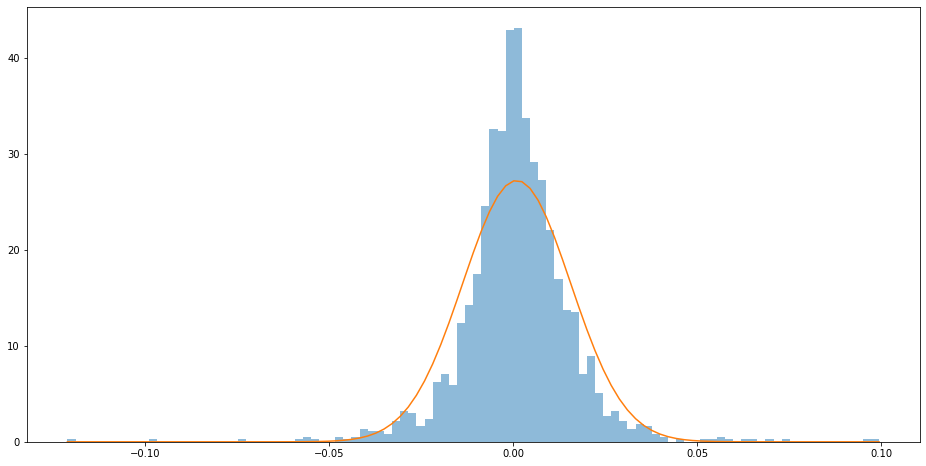

In [ ]:
# Fit a normal distribution to the data:
mu, sigma = norm.fit(x_train.values)

ig = plt.figure(figsize=(16,8))
_, bins, _ = plt.hist(x_train.values, 100, density=1, alpha=0.5)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)


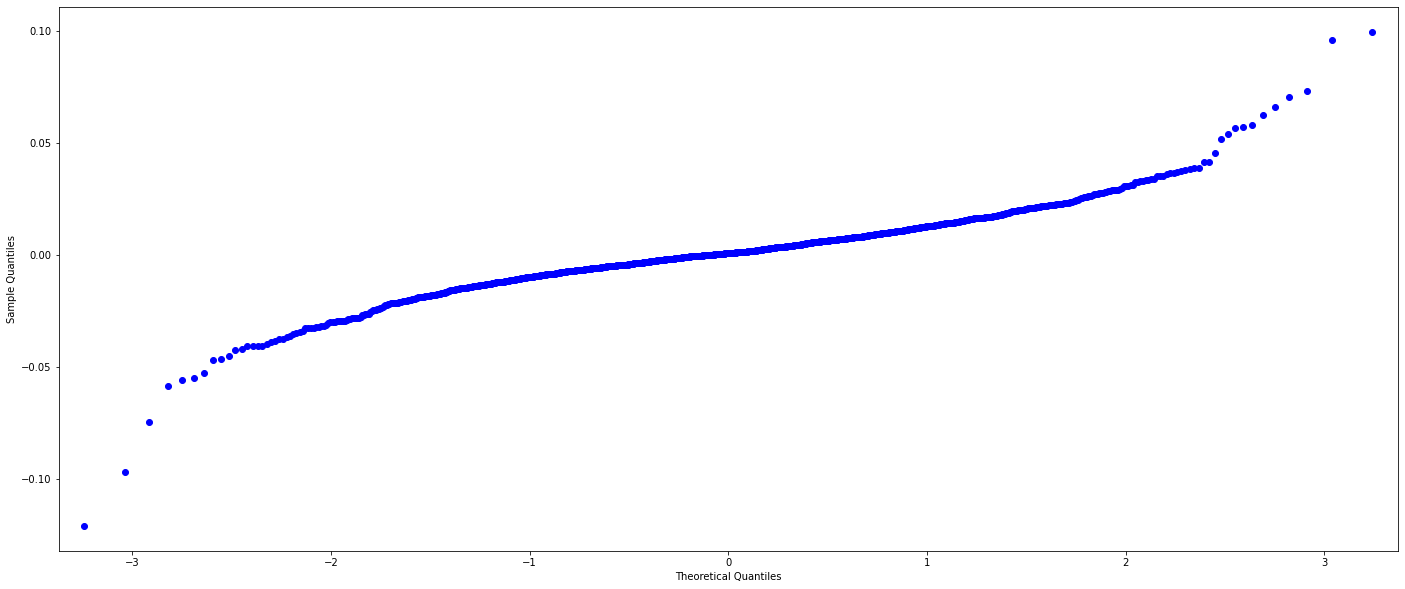

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

fig = sm.qqplot(x_train.values)

И проведем тест Дики-Фулера на стационарность

In [ ]:
def adfuller_summary(X):
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))

adfuller_summary(x_train)



ADF Statistic: -17.391990
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Согласно тесту Дики-Фуллера ряд стационарен, следовательно можно применять модели ARIMA и GARCH

## ARMA

По графикам АКФ и ЧАКФ можно выделить 2, 5 и 8 лаги как значимые. По ним и будем строить наши модели

In [ ]:
p_list = [8,5,2]

In [ ]:
q_list = [8,5,2]

In [ ]:
for p in p_list:
  for q in q_list:
    model = ARIMA(x_train, order=(p,0,q)).fit()
    print(p, q, model.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  maxiter=maxiter,


8 8 -9444.483062701494


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  maxiter=maxiter,


8 5 -9437.826843697134
8 2 -9444.633447778586


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  maxiter=maxiter,


5 8 -9442.080826304027


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  


5 5 -9443.416788417384
5 2 -9445.011378216686
2 8 -9443.351179869333
2 5 -9444.798951126295
2 2 -9442.69864479055


Лучшей согласно критерию информативности AIC является модель ARMA(5,2). Проверим ее качество по критерию RMSE на тестовой выборке и сравним со второй по информативности моделью ARMA(2, 5)

Напишем функцию считающую RMSE

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

Далее из-за проблем с функционалом пакета statsmodels перейдем к пакету sktime

Создадим набор дат по которым будем строить прогноз

In [ ]:

fh = ForecastingHorizon(
    x_test.index, 
                        is_relative=False
                        )

Обучим модели в новом пакете

In [ ]:


forecaster_1 = ARIMA_1(
    order=(5, 0, 2))
forecaster_1.fit(x_train)
forecaster_2 = ARIMA_1(
    order=(2, 0, 5))
forecaster_2.fit(x_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  maxiter=maxiter,


ARIMA(order=(2, 0, 5))

И сделаем предсказания и расчитаем RMSE

In [ ]:
pred_1 = forecaster_1.predict(fh)
pred_2 = forecaster_2.predict(fh)

In [ ]:
rmse_1 = RMSE(pred_1, x_test)
rmse_2 = RMSE(pred_2, x_test)

In [ ]:
print(rmse_1, rmse_2)

0.02025075678581938 0.020251308521802555


Модель АRMA(5,2) и по метрике RMSE также оказалась лучше - берем ее как ролевую модель для дальнейшей работы уже с GARCH.

Но в начале посмотрим на автокорреляцию в остатках

In [ ]:
model = ARIMA(x_train, order=(5,0,2)).fit()
resid = model.resid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



Date
2012-10-09   -0.017933
2012-10-10   -0.011901
2012-10-11   -0.003427
2012-10-12    0.007211
2012-10-15    0.009068
                ...   
2019-06-13    0.007908
2019-06-14    0.003712
2019-06-17    0.005683
2019-06-18    0.018597
2019-06-19    0.005512
Freq: D, Length: 1683, dtype: float64

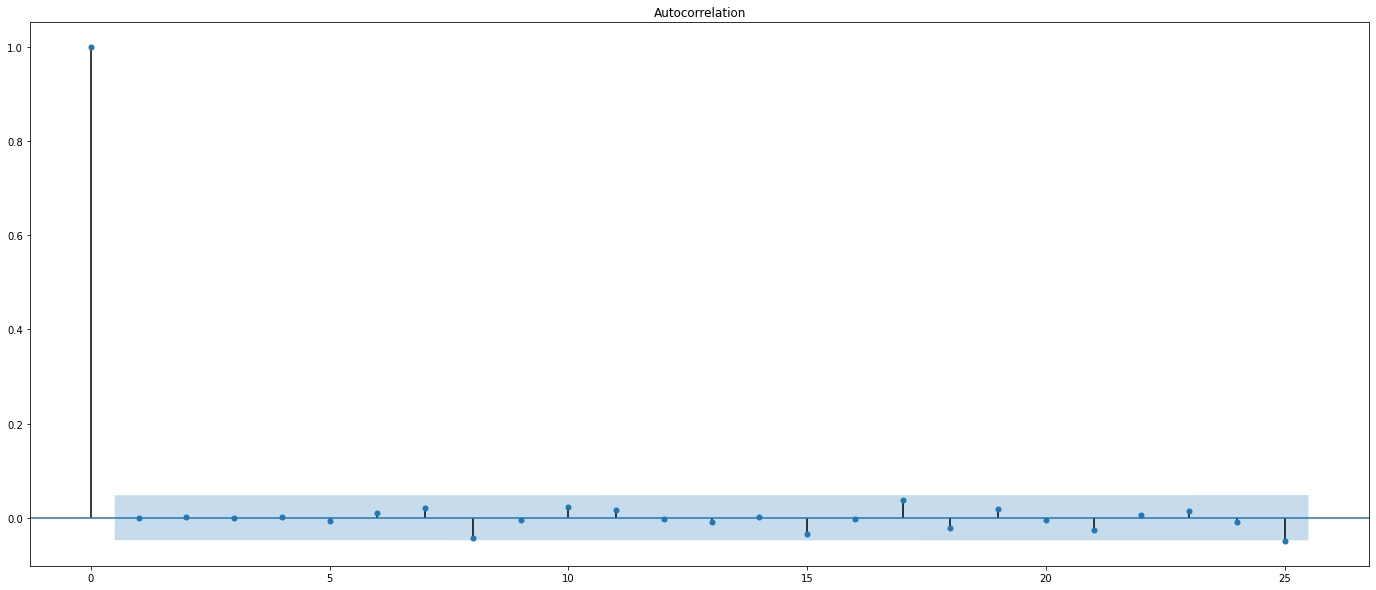

In [ ]:
plt.rc("figure", figsize=(24,10))
fig = plot_acf(resid.values.squeeze(), lags=25)

Автокорреляции в отстатках нет - модель хорошая

## GARCH

In [24]:
am = arch_model(df['log_rtns']*100,  mean='Zero', vol='GARCH', p=5, o=0, q=2)
res = am.fit(update_freq=5)
res.summary()

Iteration:      5,   Func. Count:     53,   Neg. LLF: 4748.870116203274
Iteration:     10,   Func. Count:    103,   Neg. LLF: 4596.811767699187
Iteration:     15,   Func. Count:    149,   Neg. LLF: 4594.320938311235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4594.320938311235
            Iterations: 16
            Function evaluations: 157
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:               log_rtns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4594.32
Distribution:                  Normal   AIC:                           9204.64
Method:            Maximum Likelihood   BIC:                           9251.28
                                        No. Observations:                 2513
Date:                Wed, Oct 05 2022   Df Residuals:                     2513
Time:                        06:46:16   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5846      0.473      1.235      0.217    [ -0.343,  1.513]
alpha[1]       0.2028  6.592e-02      3.076  2.100e-03  [7.356e-02,  0.332]
alpha[2]       0.1143      0.128      0.893      0.372    [ -0.136,  0.365]
alpha[3]   2.1176e-12  8.320e-02  2.545e-11      1.000    [ -0.163,  0.163]
alpha[4]       0.0965  9.189e-02      1.050      0.294 [-8.360e-02,  0.277]
alpha[5]       0.0164      0.109      0.151      0.880    [ -0.197,  0.230]
beta[1]        0.0000      0.560      0.000      1.000    [ -1.097,  1.097]
beta[2]        0.3891      0.288      1.351      0.177    [ -0.176,  0.954]
===========================================================================

Covariance estimator: robust
"""

В целом просто отдельная модель GARCH нам мало о чем говорит, поэтому обучим модель GARCH на остатках модели ARMA(5,2) и построим предсказание на этих данных

In [ ]:
model = ARIMA(x_train, order=(5,0,2)).fit()
resid = model.resid
resid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



Date
2012-10-09   -0.017933
2012-10-10   -0.011901
2012-10-11   -0.003427
2012-10-12    0.007211
2012-10-15    0.009068
                ...   
2019-06-13    0.007908
2019-06-14    0.003712
2019-06-17    0.005683
2019-06-18    0.018597
2019-06-19    0.005512
Freq: D, Length: 1683, dtype: float64

In [ ]:
garch = arch_model(resid, p=5, q=2).fit()
print(garch.summary())


Iteration:      1,   Func. Count:     11,   Neg. LLF: 6036048808.3617325
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2055.2923964757124
Iteration:      3,   Func. Count:     42,   Neg. LLF: 8729.578119621967
Iteration:      4,   Func. Count:     57,   Neg. LLF: 12319.29859664971
Iteration:      5,   Func. Count:     73,   Neg. LLF: 8041.69301673965
Iteration:      6,   Func. Count:     89,   Neg. LLF: 67885478.75027092
Iteration:      7,   Func. Count:    106,   Neg. LLF: 6316.718857789285
Iteration:      8,   Func. Count:    121,   Neg. LLF: 6458646.4463086
Iteration:      9,   Func. Count:    138,   Neg. LLF: 1614.3824015166826
Iteration:     10,   Func. Count:    152,   Neg. LLF: 2605.7939163893016
Iteration:     11,   Func. Count:    166,   Neg. LLF: -3354.837211768458
Iteration:     12,   Func. Count:    179,   Neg. LLF: 900.9215784777905
Iteration:     13,   Func. Count:    193,   Neg. LLF: 76220877.45034944
Iteration:     14,   Func. Count:    210,   Neg. LLF: -1015.85

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Мы улучшили критерий информативности AIC модели по сравнению с обычной ARMA(5,2). Построим прогноз

In [34]:
import datetime as dt
split_date = x_train.index[-1]
res = am.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4016.4955442996975
Iteration:      2,   Func. Count:     22,   Neg. LLF: 6592386.723476883
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3237.086768906952
Iteration:      4,   Func. Count:     42,   Neg. LLF: 3118.5453655573606
Iteration:      5,   Func. Count:     52,   Neg. LLF: 2986.754054720757
Iteration:      6,   Func. Count:     62,   Neg. LLF: 2976.3493932587917
Iteration:      7,   Func. Count:     72,   Neg. LLF: 3032.7888989036082
Iteration:      8,   Func. Count:     82,   Neg. LLF: 2964.125479836631
Iteration:      9,   Func. Count:     91,   Neg. LLF: 2964.0470940681384
Iteration:     10,   Func. Count:    100,   Neg. LLF: 2964.0296504186235
Iteration:     11,   Func. Count:    109,   Neg. LLF: 2964.0231936084374
Iteration:     12,   Func. Count:    118,   Neg. LLF: 2964.023049670176
Iteration:     13,   Func. Count:    127,   Neg. LLF: 2964.0230411097964
Iteration:     14,   Func. Count:    135,   Neg. LLF: 29

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


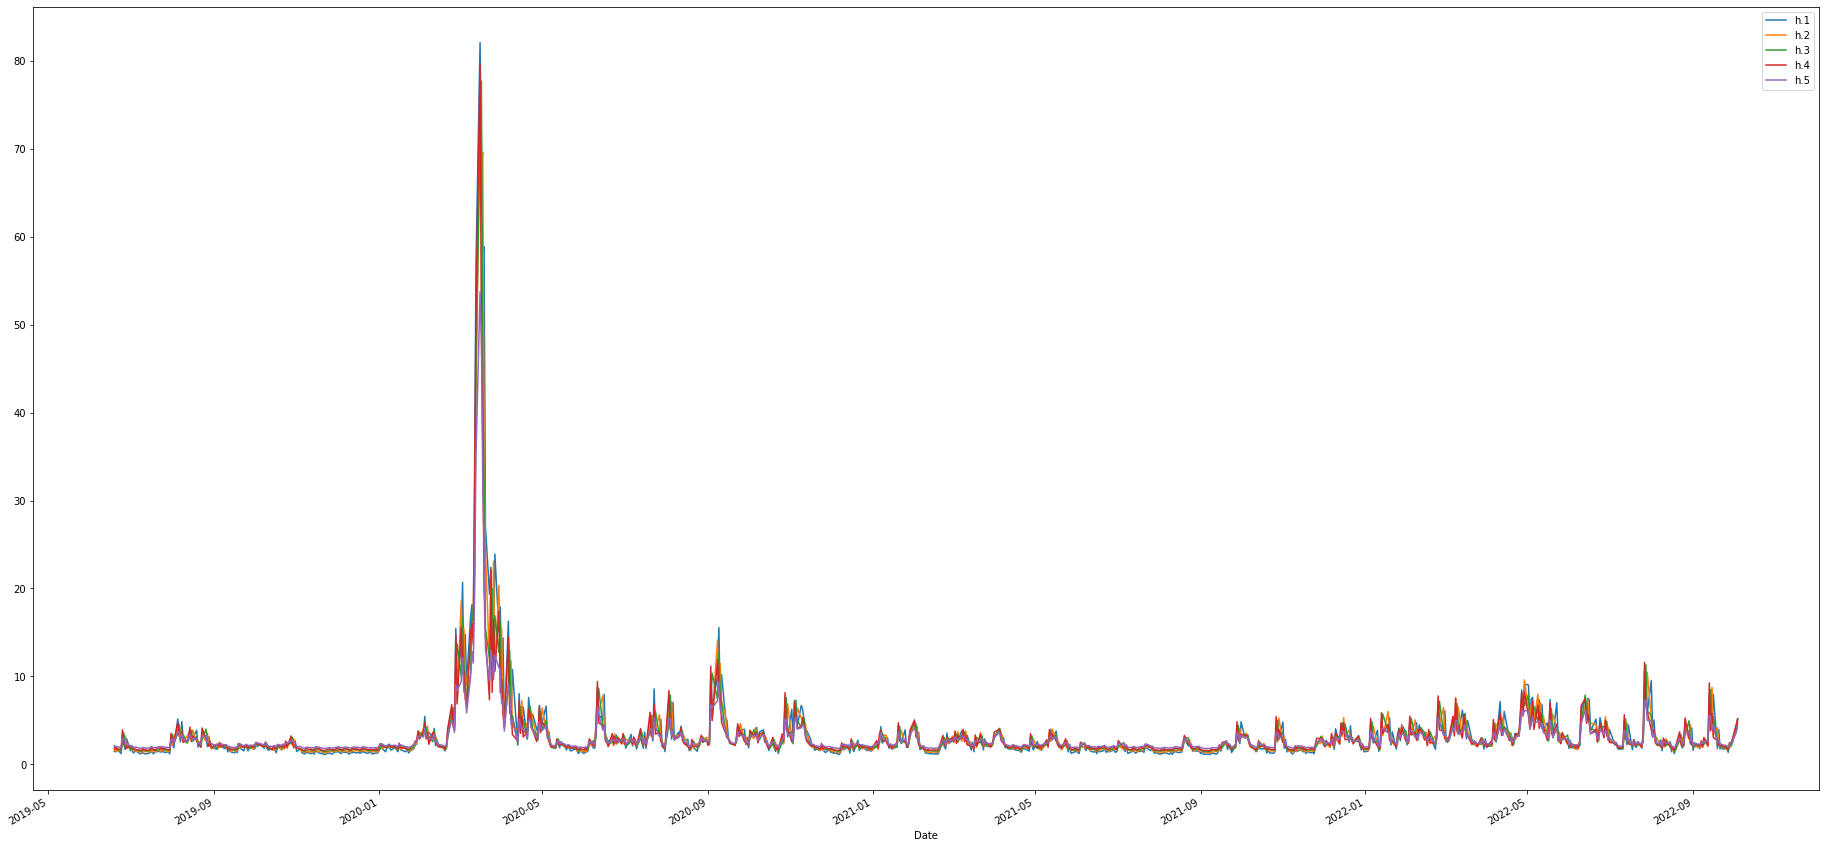

In [35]:
forecasts = res.forecast(horizon=5, start=split_date)
forecasts.variance[split_date:].plot()

Не понятно, как привести эти прогнозы к сравнению с реальными данными (посчитать RMSE), поэтому успешность GARCH модели проверить не получится(


## Вывод

К сожалению не получилось построить качественные объясненные прогнозы в GARCH - я не понял как пользоваться функциями из семинара, не нашел гайда по библиотеке в интернете, чтобы сравнить по RMSE модели.

Тем не менее, мне удалось построить качественную модель ARMA, которая не дает автокорреляции в остатках, имеет наилучший критерий информативности AIC на обучающей выборке и имеет лучшую RMSE на тестовой выборке.

Также после построения модели GARCH на остатках модели ARMA, информационный критерий AIC вырос, но из-за невозможности построить прогнозы для этой модели не получается сравнить эту модель по RMSE с другими.